In [1]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]

    # pad sequences
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)  # pad with zero for attention mask

    # convert labels to tensor
    labels = torch.tensor(labels, dtype=torch.long)  # use torch.long for classification tasks

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }


In [2]:
!pip install transformers
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 61.0 MB/s eta 0:00:00


# Import lib

In [63]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import LayerNorm
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoModel, AutoTokenizer, AdamW, get_cosine_schedule_with_warmup
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
import re
import nltk
from nltk.tokenize import word_tokenize
import math
from google.colab import drive
from tqdm.auto import tqdm
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Import dataset

In [4]:
! git clone https://github.com/duongnghia222/News_classification

Cloning into 'News_classification'...
remote: Enumerating objects: 445, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 445 (delta 19), reused 32 (delta 11), pack-reused 402
Receiving objects: 100% (445/445), 104.20 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Updating files: 100% (55/55), done.


In [5]:
# Load data from CSV file
df = pd.read_csv('News_classification/data/raw_data/raw_data.csv', encoding='utf-8-sig')

# Visualize Data

In [6]:
df.tail()

,Content,Label
10391,"Một cá nhân bất ngờ mua vào 30,77 triệu cổ phi...",TTF
10392,"Chưa kịp bán ra, Chủ tịch Đỗ Quý Hải tiếp tục ...",HPX
10393,POM cho cán bộ nhân viên nghỉ việc vì dừng lò ...,POM
10394,Năm Bảy Bảy (NBB) chấp thuận cho Công ty con c...,NBB
10395,Chứng khoán Ngân hàng Sài Gòn Thương Tín (SBS)...,SBS


In [7]:
# Count the number of words in each article's content and number of times a class appear
df['Word Count'] = df['Content'].apply(lambda x: len(str(x).split()))
df['Class Count'] = df.groupby('Label')['Label'].transform('count')

# Calculate statistics for word count
df['Word Count'].describe()

count    10396.000000
mean       607.325414
std        352.123889
min         46.000000
25%        381.000000
50%        514.000000
75%        725.250000
max       4235.000000
Name: Word Count, dtype: float64

In [8]:
df.head()

,Content,Label,Word Count,Class Count
0,"Vingroup báo lãi hơn 3.600 tỷ đồng, doanh thu ...",VIC,599,108
1,HAGL Agrico (HNG) lỗ quý thứ 5 liên tiếp. Giá ...,HNG,642,65
2,"Vingroup lãi ròng 1.028 tỷ đồng nửa đầu năm, t...",VIC,577,108
3,Một doanh nghiệp khoáng sản đã vượt 153% mục t...,KSV,430,3
4,Doanh nghiệp thép từ lớn đến nhỏ đều báo lỗ qu...,HPG,1247,197


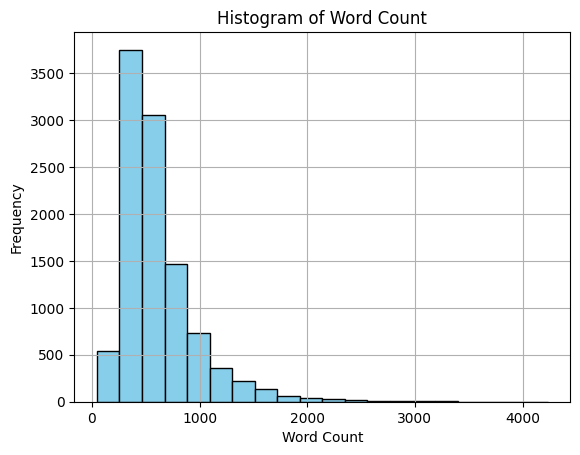

In [9]:
# Plot histogram for word count
plt.hist(df['Word Count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [10]:
# Count the occurrence of each unique label
label_counts = df['Label'].value_counts()
print(label_counts.describe())

# Loop over each unique label and print its count
# for label, count in label_counts.items():
#     print(f"Label: {label}, Count: {count}")

count    927.000000
mean      11.214671
std       21.224713
min        1.000000
25%        1.000000
50%        3.000000
75%       11.000000
max      197.000000
Name: Label, dtype: float64


In [11]:
# extracted_df
e_df = df.loc[df['Class Count'] > 5].sort_values(by="Class Count", ascending=False)
e_df.count()

Content        9222
Label          9222
Word Count     9222
Class Count    9222
dtype: int64

In [12]:
number_of_classes = e_df['Label'].nunique()
number_of_classes

350

# Processing Dataset

## Clean text

In [13]:
with open('/content/News_classification/vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    vietnamese_stopwords = f.read().splitlines()

vietnamese_stopwords[:10]

['a lô',
 'a ha',
 'ai',
 'ai ai',
 'ai nấy',
 'ai đó',
 'alô',
 'amen',
 'anh',
 'anh ấy']

In [14]:
def clean_text(txt):
    txt = re.sub('\s+', ' ', txt)
    txt = txt.replace('.','')
    txt = re.sub('\n', ' ', txt)
    txt = [word_tokenize(wrd) for wrd in txt.split() if wrd not in vietnamese_stopwords]
    txt = [item[0] for item in txt]
    txt = ' '.join(txt)
    return txt

clean_text(" VinFast chính thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S tại 24 tỉnh, thành phố trên cả nước")

'VinFast thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S 24 tỉnh thành phố'

In [15]:
# e_df['Content'] = e_df['Content'].apply(clean_text)
e_df.head()

,Content,Label,Word Count,Class Count
1781,"Hòa Phát: Lợi nhuận quý IV tăng 59%, cả năm đạ...",HPG,675,197
7905,"Hòa Phát lãi 4 ngàn tỷ trong quý 2, giảm gần 6...",HPG,336,197
5725,Chủ tịch Trần Đình Long (HPG): Giai đoạn thảm ...,HPG,977,197
3000,Tại sao Hòa Phát nâng tỷ lệ cổ tức mặc dù cổ đ...,HPG,919,197
2512,Hòa Phát dự kiến khởi công dự án 85.000 tỷ vào...,HPG,452,197


## Transform labels

In [16]:
labels_list = e_df['Label'].tolist()
print(labels_list[:10])

['HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG']


In [17]:
le = LabelEncoder()
labels = le.fit_transform(labels_list).tolist()
print(labels[-10:])

[166, 13, 121, 52, 121, 219, 151, 299, 309, 132]


In [18]:
e_df['Encode Label'] = labels
e_df.head(10)

,Content,Label,Word Count,Class Count,Encode Label
1781,"Hòa Phát: Lợi nhuận quý IV tăng 59%, cả năm đạ...",HPG,675,197,122
7905,"Hòa Phát lãi 4 ngàn tỷ trong quý 2, giảm gần 6...",HPG,336,197,122
5725,Chủ tịch Trần Đình Long (HPG): Giai đoạn thảm ...,HPG,977,197,122
3000,Tại sao Hòa Phát nâng tỷ lệ cổ tức mặc dù cổ đ...,HPG,919,197,122
2512,Hòa Phát dự kiến khởi công dự án 85.000 tỷ vào...,HPG,452,197,122
4957,Công ty con nào chuyển nhiều lợi nhuận nhất về...,HPG,604,197,122
5328,Loạt đại gia ngành thép báo 'tin buồn’ trong q...,HPG,1333,197,122
2066,"Hòa Phát, Formosa đứng thứ mấy thế giới về sản...",HPG,664,197,122
1777,Hòa Phát nộp ngân sách gần 7.400 tỷ đồng trong...,HPG,602,197,122
1070,Hòa Phát: Tiêu thụ thép xây dựng tháng 2 gấp 2...,HPG,534,197,122


## Split trainset valset

In [19]:
y = e_df['Encode Label']

In [20]:
trainset, valset = train_test_split(e_df, test_size=0.2, stratify=y, random_state=42)

# Load phoBERT tokenizer

In [21]:
# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
text = "công tyNếu tính GJK"
print(tokenizer.encode(text))
text = "công ty Nếu tính gjk"
print(tokenizer.encode(text))

[0, 675, 6745, 313, 294, 1276, 2136, 2260, 2]
[0, 675, 6892, 313, 294, 1529, 57202, 2]


# Hyperparameters


In [23]:
MAX_LENGTH = 256  # Adjust as needed
BATCH_SIZE = 32
N_CLASSES = number_of_classes  # Replace with your actual number of classes
EPOCHS = 30

# ArticleDataset Class

In [24]:
class ArticleDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_length=256):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        label = item.get('Encode Label')
        encoding = self.tokenizer.encode_plus(
            text=item.Content,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        # labels_tensor = torch.FloatTensor(label)
        # print(label)
        return {
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



In [25]:
x = torch.tensor([1, 2, 3, 4, 5])
print(x.shape)

torch.Size([5])


In [26]:
a_ds = ArticleDataset(trainset, labels, tokenizer, MAX_LENGTH)
sample_item = a_ds[0]
print(len(a_ds))
sample_item.keys()


7377


dict_keys(['input_ids', 'attention_mask', 'labels'])

In [27]:
print(sample_item["input_ids"].shape)
print(sample_item["labels"].shape)
print(sample_item["labels"])
print(le.inverse_transform([106]))

torch.Size([256])
torch.Size([])
tensor(106)
['HAG']


# Pytorch Lightning DataModule

In [28]:
class Data_Module(pl.LightningDataModule):
    def __init__(self, trainset, valset, labels, batch_size: int = 32, max_token_length: int = 256, tokenizer=None):
      super().__init__()
      self.trainset = trainset
      self.val_path = valset
      self.labels = labels
      self.batch_size = batch_size
      self.max_token_length = max_token_length
      self.tokenizer = tokenizer

    def setup(self, stage = None):
      if stage in (None, "fit"):
        self.train_dataset = ArticleDataset(self.trainset, self.labels, self.tokenizer, self.max_token_length)
        self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)
      if stage == 'predict':
        self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)

    def train_dataloader(self):
      return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=2, shuffle=True)

    def val_dataloader(self):
      return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

    def predict_dataloader(self):
      return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

# Create PyTorch lightning DataLoader

In [29]:
# Create PyTorch lightning DataLoader
data_loader = Data_Module(trainset, valset, labels, BATCH_SIZE, MAX_LENGTH, tokenizer)
data_loader.setup()
len(data_loader.train_dataloader())

231

# Model architecture

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [49]:
class ArticleClassifier(pl.LightningModule):
    def __init__(self, config: dict, freeze_bert=False):
        super().__init__()
        self.config = config
        self.bert = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 128)  # Adjusted the input size to match the bert's hidden size
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 256)
        self.dropout2 = nn.Dropout(0.4)
        self.layer_norm = LayerNorm(256)
        self.output = nn.Linear(256, self.config['n_labels'])
        self.loss = nn.CrossEntropyLoss()



    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask).last_hidden_state
        x = torch.mean(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.layer_norm(x)
        logits = self.output(x)  # Remove softmax activation here
        return logits


    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        logits = self(input_ids, attention_mask)
        print("ts-l", logits.requires_grad)
        print("ts-la", labels.requires_grad)
        loss = self.loss(logits, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": logits, "labels": labels}


    # def validation_step(self, batch, batch_idx):
    #     input_ids = batch["input_ids"]
    #     attention_mask = batch["attention_mask"]
    #     labels = batch["labels"]
    #     logits = self(input_ids, attention_mask)
    #     loss = self.loss(logits, labels)
    #     self.log("val_loss", loss, prog_bar=True, logger=True)
    #     return loss


    # def test_step(self, batch, batch_idx):
    #     input_ids = batch["input_ids"]
    #     attention_mask = batch["attention_mask"]
    #     labels = batch["labels"]
    #     logits = self(input_ids, attention_mask)
    #     loss = self.loss(logits, labels)
    #     self.log("test_loss", loss, prog_bar=True, logger=True)
    #     return loss


    # def configure_optimizers(self):
    #     optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
    #     total_steps = self.config['train_size']/self.config['batch_size']
    #     warmup_steps = math.floor(total_steps * self.config['warmup'])
    #     warmup_steps = math.floor(total_steps * self.config['warmup'])
    #     scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    #     return [optimizer],[scheduler]

# Initialize Model

## Model configuration

In [50]:
config = {
    'model_name': 'vinai/phobert-base-v2',
    'n_labels': number_of_classes,
    'batch_size': BATCH_SIZE,
    'lr': 1.5e-6,
    'warmup': 0.2,
    'train_size': len(data_loader.train_dataloader()),
    'weight_decay': 0.001,
    'n_epochs': 100
}

## Create model

In [51]:
# Initialize our classifier
model = ArticleClassifier(config, freeze_bert=True)
model = model.to(device)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

In [44]:
idx=0
input_ids_ = a_ds.__getitem__(idx)['input_ids']
attention_mask_ = a_ds.__getitem__(idx)['attention_mask']
print(input_ids_.requires_grad)
print(attention_mask_.requires_grad)
labels_ = a_ds.__getitem__(idx)['labels']
model.cpu()
output = model(input_ids_.unsqueeze(dim=0), attention_mask_.unsqueeze(dim=0))
print(labels_.shape, output.shape)

False
False
training: f-l True
torch.Size([]) torch.Size([1, 350])


In [35]:
test_batch = next(iter(data_loader.train_dataloader()))
test_batch_input_ids = test_batch['input_ids']
print(test_batch_input_ids.shape)
output = model(test_batch['input_ids'], test_batch['attention_mask'])
print(labels_.shape, output.shape)

torch.Size([32, 256])
torch.Size([]) torch.Size([32, 350])


In [36]:
test_batch_labels = test_batch['labels']
test_batch_labels.shape

torch.Size([32])


# Train Model

In [62]:
def train_model(model, data_loader, config):
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    total_steps = config['train_size']/config['batch_size']
    warmup_steps = math.floor(total_steps * config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    best_valid_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_limit = 5  # Number of epochs with no improvement after which training will be stopped
    model_path = 'best_model.pt'  # path where best model will be saved

    progress_bar = tqdm(range(config['n_epochs']), desc="Training", total=config['n_epochs'])

    for epoch in progress_bar:
        model.train()
        total_loss = 0

        for batch in data_loader.train_dataloader():
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)

            loss = model.loss(logits, labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(data_loader.train_dataloader())

        # Start the validation
        model.eval()

        predictions , true_labels = [], []
        total_eval_loss = 0

        for batch in data_loader.val_dataloader():
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with torch.no_grad():
                logits = model(input_ids, attention_mask)

            loss = model.loss(logits, labels)
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            labels = labels.to('cpu').numpy()

            # Store predictions and true labels
            predictions.append(logits)
            true_labels.append(labels)

        # Calculate the average loss over all of the batches
        avg_val_loss = total_eval_loss / len(data_loader.val_dataloader())

        # Calculate validation accuracy
        predictions = np.concatenate(predictions, axis=0)
        true_labels = np.concatenate(true_labels, axis=0)
        val_accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))

        # Update progress bar
        progress_bar.set_postfix({'train_loss': avg_train_loss, 'valid_loss': avg_val_loss, 'valid_acc': val_accuracy})

        # save model if validation loss has decreased
        if avg_val_loss < best_valid_loss:
            best_valid_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            early_stopping_counter = 0  # reset counter
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_limit:
                print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_limit}')
                if early_stopping_counter >= early_stopping_limit:
                    print('Early stopping, stopping training')
                    break  # break out from the training loop


In [64]:
train_model(model, data_loader, config)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: ignored